<a href="https://colab.research.google.com/github/mvidela31/MA4402/blob/main/MA4402_Proyecto_HMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MA4402 Simulación Estocástica: Teoría y Laboratorio
# Proyecto: Hamiltonian Monte Carlo
### Integrantes: Mario Vicuña y Miguel Videla

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
seed = 2077

## Probability Distributions

In [ ]:
### Distributions implementation
class GaussianDist():
    '''Multivariate Gaussian distrubution'''
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.invcov = np.linalg.inv(cov)

    def pdf(self, x):
        return st.multivariate_normal.pdf(x.squeeze(), mean=self.mean.squeeze(), cov=self.cov)

    def logpdf(self, x):
        return st.multivariate_normal.logpdf(x.squeeze(), mean=self.mean.squeeze(), cov=self.cov)

    def grad_log(self, x):
        return -self.invcov @ (x - self.mean)


class BananaDist():
    '''Bivariate Banana distribution'''
    def __init__(self, sigma_theta=1, sigma_y=2, K=100, seed=None):
        R = np.random.RandomState(seed)
        self.sigma_theta = sigma_theta
        self.sigma_y = sigma_y
        self.y_k = R.normal(loc=1, scale=sigma_y, size=K)

    def pdf(self, x):
        return st.norm.pdf(self.y_k, loc=x[0] + x[1] ** 2, scale=self.sigma_y).prod() \
                * st.norm.pdf(x[0], loc=0, scale=self.sigma_theta) \
                * st.norm.pdf(x[1], loc=0, scale=self.sigma_theta)

    def logpdf(self, x):
        return st.norm.logpdf(self.y_k, loc=x[0] + x[1] ** 2, scale=self.sigma_y).sum() \
                + st.norm.logpdf(x[0], loc=0, scale=self.sigma_theta) \
                + st.norm.logpdf(x[1], loc=0, scale=self.sigma_theta)

    def grad_log(self, x):
        dtheta = ((self.y_k - (x[0] + x[1] ** 2)) / self.sigma_y ** 2).sum()
        dtheta_1 = dtheta * 1 * x[0] - x[0] / self.sigma_theta ** 2
        dtheta_2 = dtheta * 2 * x[1] - x[1] / self.sigma_theta ** 2
        return np.array([dtheta_1, dtheta_2])


class DoughnutDist():
    '''Bivariate Doughnut distribution'''
    def __init__(self, sigma_theta=1, sigma_y=2, K=100, seed=None):
        R = np.random.RandomState(seed)
        self.sigma_theta = sigma_theta
        self.sigma_y = sigma_y
        self.y_k = R.normal(loc=1, scale=sigma_y, size=K)

    def pdf(self, x):
        return st.norm.pdf(self.y_k, loc=x[0] ** 2 + x[1] ** 2, scale=self.sigma_y).prod() \
                * st.norm.pdf(x[0], loc=0, scale=self.sigma_theta) \
                * st.norm.pdf(x[1], loc=0, scale=self.sigma_theta)

    def logpdf(self, x):
        return st.norm.logpdf(self.y_k, loc=x[0] ** 2 + x[1] ** 2, scale=self.sigma_y).sum() \
                + st.norm.logpdf(x[0], loc=0, scale=self.sigma_theta) \
                + st.norm.logpdf(x[1], loc=0, scale=self.sigma_theta)

    def grad_log(self, x):
        dtheta = ((self.y_k - (x[0] ** 2 + x[1] ** 2)) / self.sigma_y ** 2).sum()
        dtheta_1 = dtheta * 2 * x[0] - x[0] / self.sigma_theta ** 2
        dtheta_2 = dtheta * 2 * x[1] - x[1] / self.sigma_theta ** 2
        return np.array([dtheta_1, dtheta_2])

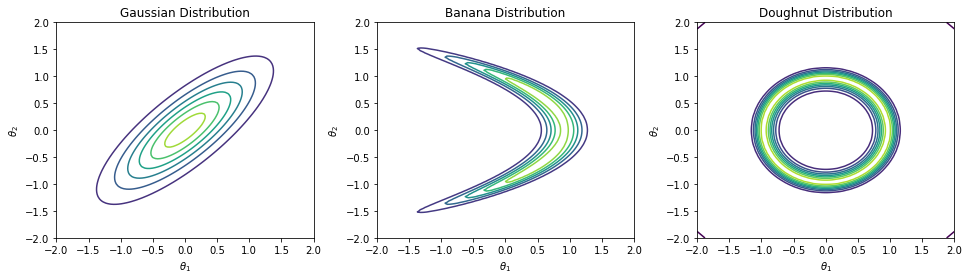

In [ ]:
### Distributions visualization
gaussian_dist = GaussianDist(mean=np.array([[0],[0]]), cov=np.array([[0.5,0.4],[0.4,0.5]]))
banana_dist = BananaDist(seed=seed)
doughnut_dist = DoughnutDist(seed=seed)

theta_1 = np.linspace(-2, 2, 100)
theta_2 = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(theta_1, theta_2)
X_rav = np.ravel(X); Y_rav = np.ravel(Y)
zs_gaussian = []; zs_banana = []; zs_doughnut = []
for i in range(X_rav.size):
    zs_gaussian.append(gaussian_dist.pdf(np.array([X_rav[i], Y_rav[i]])))
    zs_banana.append(banana_dist.pdf(np.array([X_rav[i], Y_rav[i]])))
    zs_doughnut.append(doughnut_dist.pdf(np.array([X_rav[i], Y_rav[i]])))
Z_gaussian = np.array(zs_gaussian).reshape(X.shape)
Z_banana = np.array(zs_banana).reshape(X.shape)
Z_doughnut = np.array(zs_doughnut).reshape(X.shape)

plt.figure(figsize=(13.5,4))
plt.subplot(1,3,1)
plt.contour(X, Y, Z_gaussian)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution')
plt.subplot(1,3,2)
plt.contour(X, Y, Z_banana)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution')
plt.subplot(1,3,3)
plt.contour(X, Y, Z_doughnut)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution')
plt.tight_layout()
plt.savefig('distributions.png', dpi=300, transparent=True)
plt.show()

## Markov Chain Monte Carlo Methods

In [ ]:
### MCMC methods implementation
def MH(dist, x0, M, iterations=1000):
    '''Metropolis-Hastings algorithm'''
    samples = [x0]
    accepted_samples = 0
    for _ in tqdm(range(iterations)):
        x = samples[-1]
        xc = x + np.expand_dims(np.random.multivariate_normal(mean=np.zeros(x0.size), cov=M), axis=1)
        if np.random.uniform() <= min(1, dist.pdf(xc) / dist.pdf(x)):
            samples.append(xc)
            accepted_samples += 1
        else:
            samples.append(x)
    return np.array(samples).squeeze(), accepted_samples / iterations


def HMC(dist, x0, M, L=5, epsilon=0.1, iterations=1000, return_leapfrog_paths=False):
    '''Hamiltonian Monte Carlo algorithm'''
    samples = [x0]
    inv_M = np.linalg.inv(M)
    det_M = np.linalg.det(M)
    leapfrog_paths = []
    accepted_samples = 0
    for _ in tqdm(range(iterations)):
        q0 = np.copy(samples[-1])
        qL = np.copy(q0)
        p0 = np.expand_dims(np.random.multivariate_normal(mean=np.zeros(x0.size), cov=M), axis=1)
        pL = np.copy(p0)
        if return_leapfrog_paths:
            leapfrog_path = [np.copy(qL)]
        for _ in range(L):
            pL += (epsilon / 2) * dist.grad_log(qL)
            qL += epsilon * pL
            pL += (epsilon / 2) * dist.grad_log(qL)
            if return_leapfrog_paths:
                leapfrog_path.append(np.copy(qL))
        pL *= -1
        H0 = 0.5 * p0.T @ inv_M @ p0 + np.log(det_M) - dist.logpdf(q0)
        HL = 0.5 * pL.T @ inv_M @ pL + np.log(det_M) - dist.logpdf(qL)
        if np.random.uniform() <= min(1, np.exp(-HL + H0)):
            samples.append(qL)
            accepted_samples += 1
            if return_leapfrog_paths:
                leapfrog_paths.append(np.array(leapfrog_path).squeeze())
        else:
            samples.append(q0)
            if return_leapfrog_paths:
                leapfrog_paths.append(np.array([q0] * int(L / epsilon)).squeeze())
    if return_leapfrog_paths:
        return np.array(samples).squeeze(), accepted_samples / iterations, leapfrog_paths
    else:
        return np.array(samples).squeeze(), accepted_samples / iterations
        

def NUTS(dist, θ0, ϵ=0.1, iterations=1000, delta_max=1000, return_leapfrog_paths=False):
    '''No-U-Turn Sampler Hamiltonian Monte Carlo algorithm'''
    def BuildTree(dist, θ, r, u, v, j, ϵ, delta_max, leapfrog_path=None):
        if j == 0:
            # Base case — take one leapfrog step in the direction v.
            r1 = r + (v * ϵ / 2) * dist.grad_log(θ)
            θ1 = θ + (v * ϵ) * r1
            r1 = r1 + (v * ϵ / 2) * dist.grad_log(θ1)
            n1 = int(u <= np.exp(dist.logpdf(θ1) - 0.5 * r1.T @ r1))
            s1 = int(u < np.exp(delta_max + dist.logpdf(θ1) - 0.5 * r1.T @ r1))
            if leapfrog_path:
                leapfrog_path.append(θ1)
            return θ1, r1, θ1, r1, θ1, n1, s1
        else:
            # Recursion — implicitly build the left and right subtrees.
            θ_l, r_l, θ_r, r_r, θ1, n1, s1 = BuildTree(dist, θ, r, u, v, j-1, ϵ, delta_max, leapfrog_path)
            if s1 == 1:
                if v == -1:
                    θ_l, r_l, _, _, θ2, n2, s2 = BuildTree(dist, θ_l, r_l, u, v, j-1, ϵ, delta_max, leapfrog_path)
                else:
                    _, _, θ_r, r_r, θ2, n2, s2 = BuildTree(dist, θ_r, r_r, u, v, j-1, ϵ, delta_max, leapfrog_path)
                if np.random.uniform() <= (n2 / max(n1 + n2, 1)):
                    θ1 = θ2
                s1 = s2 * int((θ_r - θ_l).T @ r_l >= 0) * int((θ_r - θ_l).T @ r_r >= 0)
                n1 = n1 + n2
            return θ_l, r_l, θ_r, r_r, θ1, n1, s1

    samples = [θ0]
    leapfrog_paths = []
    leapfrog_path_l = leapfrog_path_r = None
    accepted_samples = 0
    for _ in tqdm(range(iterations)):
        r0 = np.expand_dims(np.random.multivariate_normal(mean=np.zeros(θ0.size), cov=np.eye(θ0.size)), axis=1)
        u = np.random.uniform(low=0, high=np.exp(dist.logpdf(samples[-1]) - 0.5 * r0.T @ r0))
        θ_l = np.copy(samples[-1]); θ_r = np.copy(samples[-1])
        r_l = np.copy(r0); r_r = np.copy(r0)
        j = 0
        θm = np.copy(samples[-1])
        n = s = 1
        acceptance = 0
        if return_leapfrog_paths:
            leapfrog_path = np.array([np.copy(θm)]).squeeze()
            leapfrog_path_l = [np.copy(θm)]
            leapfrog_path_r = [np.copy(θm)]
        while s == 1:
            vj = np.random.choice([-1, 1])
            if vj == -1:
                θ_l, r_l, _, _, θ1, n1, s1 = BuildTree(dist, θ_l, r_l, u, vj, j, ϵ, delta_max, leapfrog_path_l)
            else:
                _, _, θ_r, r_r, θ1, n1, s1 = BuildTree(dist, θ_r, r_r, u, vj, j, ϵ, delta_max, leapfrog_path_r)
            if s1 == 1:
                if np.random.uniform() <= min(1, n1 / n):
                    θm = θ1
                    acceptance = 1
                    if return_leapfrog_paths:
                        if vj == -1:
                            leapfrog_path = np.copy(np.array(leapfrog_path_l).squeeze())
                        else:
                            leapfrog_path = np.copy(np.array(leapfrog_path_r).squeeze())
                        last_leapfrog_idx = np.where(np.all(leapfrog_path == θm.squeeze(), axis=1))[0][0]
                        leapfrog_path = leapfrog_path[0:last_leapfrog_idx+1]
            n = n + n1
            s = s1 * int((θ_r - θ_l).T @ r_l >= 0) * int((θ_r - θ_l).T @ r_r >= 0)
            j = j + 1
        samples.append(θm)
        accepted_samples += acceptance
        if return_leapfrog_paths:
            leapfrog_paths.append(leapfrog_path)
    if return_leapfrog_paths:
        return np.array(samples).squeeze(), accepted_samples / iterations, leapfrog_paths
    else:
        return np.array(samples).squeeze(), accepted_samples / iterations

In [ ]:
### MCMC methods on multiple distributions
samples_gaussian_mh, ar_gaussian_mh = MH(dist=gaussian_dist, x0=np.array([[1.0], [1.0]]), M=0.1*np.eye(2))
samples_banana_mh, ar_banana_mh = MH(dist=banana_dist, x0=np.array([[1.0], [0.0]]), M=0.1*np.eye(2))
samples_doughnut_mh, ar_doughnut_mh = MH(dist=doughnut_dist, x0=np.array([[1.0], [0.0]]), M=0.1*np.eye(2))
samples_gaussian_hmc, ar_gaussian_hmc, paths_gaussian_hmc = HMC(dist=gaussian_dist, x0=np.array([[1.0], [1.0]]), M=np.eye(2), return_leapfrog_paths=True)
samples_banana_hmc, ar_banana_hmc, paths_banana_hmc = HMC(dist=banana_dist, x0=np.array([[1.0], [0.0]]), M=np.eye(2), return_leapfrog_paths=True)
samples_doughnut_hmc, ar_doughnut_hmc, paths_doughnut_hmc = HMC(dist=doughnut_dist, x0=np.array([[1.0], [0.0]]), M=np.eye(2), return_leapfrog_paths=True)
samples_gaussian_nuts, ar_gaussian_nuts, paths_gaussian_nuts = NUTS(dist=gaussian_dist, θ0=np.array([[1.0], [1.0]]), return_leapfrog_paths=True)
samples_banana_nuts, ar_banana_nuts, paths_banana_nuts = NUTS(dist=banana_dist, θ0=np.array([[1.0], [0.0]]), return_leapfrog_paths=True)
samples_doughnut_nuts, ar_doughnut_nuts, paths_doughnut_nuts = NUTS(dist=doughnut_dist, θ0=np.array([[1.0], [0.0]]), return_leapfrog_paths=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in exp


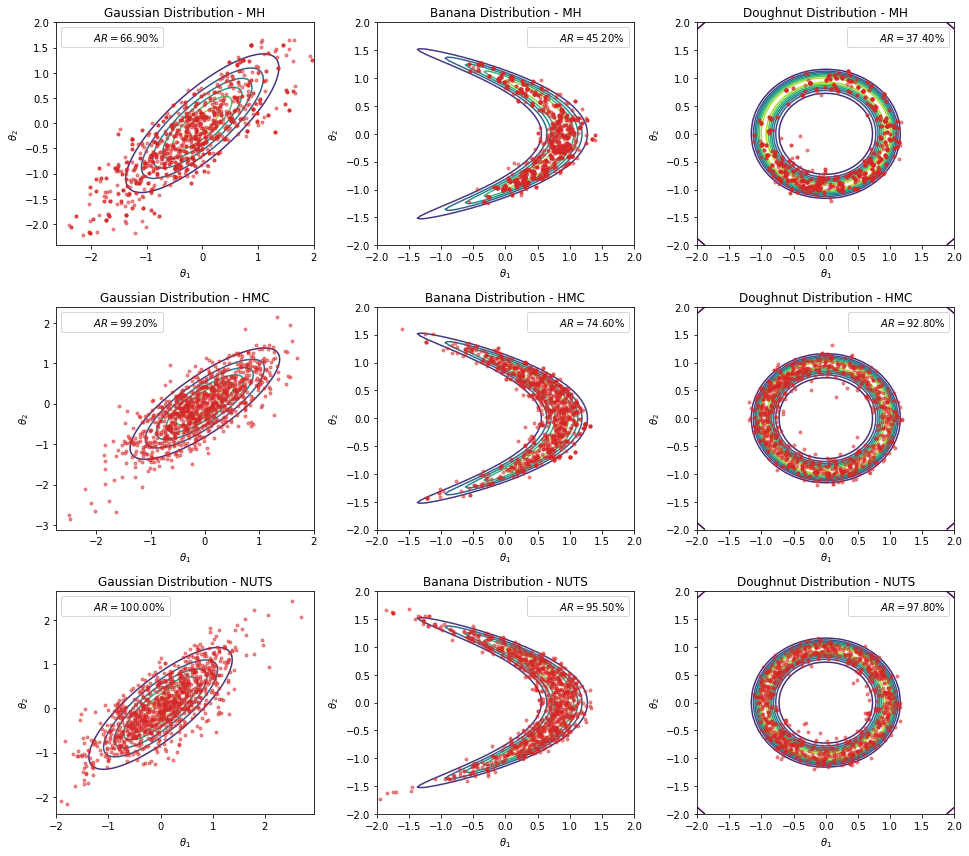

In [ ]:
### Generated samples
plt.figure(figsize=(13.5,12))
plt.subplot(3,3,1)
plt.contour(X, Y, Z_gaussian)
plt.plot(samples_gaussian_mh[:,0], samples_gaussian_mh[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_gaussian_mh))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - MH')
plt.legend()
plt.subplot(3,3,2)
plt.contour(X, Y, Z_banana)
plt.plot(samples_banana_mh[:,0], samples_banana_mh[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_banana_mh))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - MH')
plt.legend()
plt.subplot(3,3,3)
plt.contour(X, Y, Z_doughnut)
plt.plot(samples_doughnut_mh[:,0], samples_doughnut_mh[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_doughnut_mh))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - MH')
plt.legend()
plt.subplot(3,3,4)
plt.contour(X, Y, Z_gaussian)
plt.plot(samples_gaussian_hmc[:,0], samples_gaussian_hmc[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_gaussian_hmc))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - HMC')
plt.legend()
plt.subplot(3,3,5)
plt.contour(X, Y, Z_banana)
plt.plot(samples_banana_hmc[:,0], samples_banana_hmc[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_banana_hmc))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - HMC')
plt.legend()
plt.subplot(3,3,6)
plt.contour(X, Y, Z_doughnut)
plt.plot(samples_doughnut_hmc[:,0], samples_doughnut_hmc[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_doughnut_hmc))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - HMC')
plt.legend()
plt.subplot(3,3,7)
plt.contour(X, Y, Z_gaussian)
plt.plot(samples_gaussian_nuts[:,0], samples_gaussian_nuts[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_gaussian_nuts))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - NUTS')
plt.legend()
plt.subplot(3,3,8)
plt.contour(X, Y, Z_banana)
plt.plot(samples_banana_nuts[:,0], samples_banana_nuts[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_banana_nuts))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - NUTS')
plt.legend()
plt.subplot(3,3,9)
plt.contour(X, Y, Z_doughnut)
plt.plot(samples_doughnut_nuts[:,0], samples_doughnut_nuts[:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * ar_doughnut_nuts))
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - NUTS')
plt.legend()
plt.tight_layout()
plt.savefig('comparisson_ar.png', dpi=300, transparent=True)
plt.show()

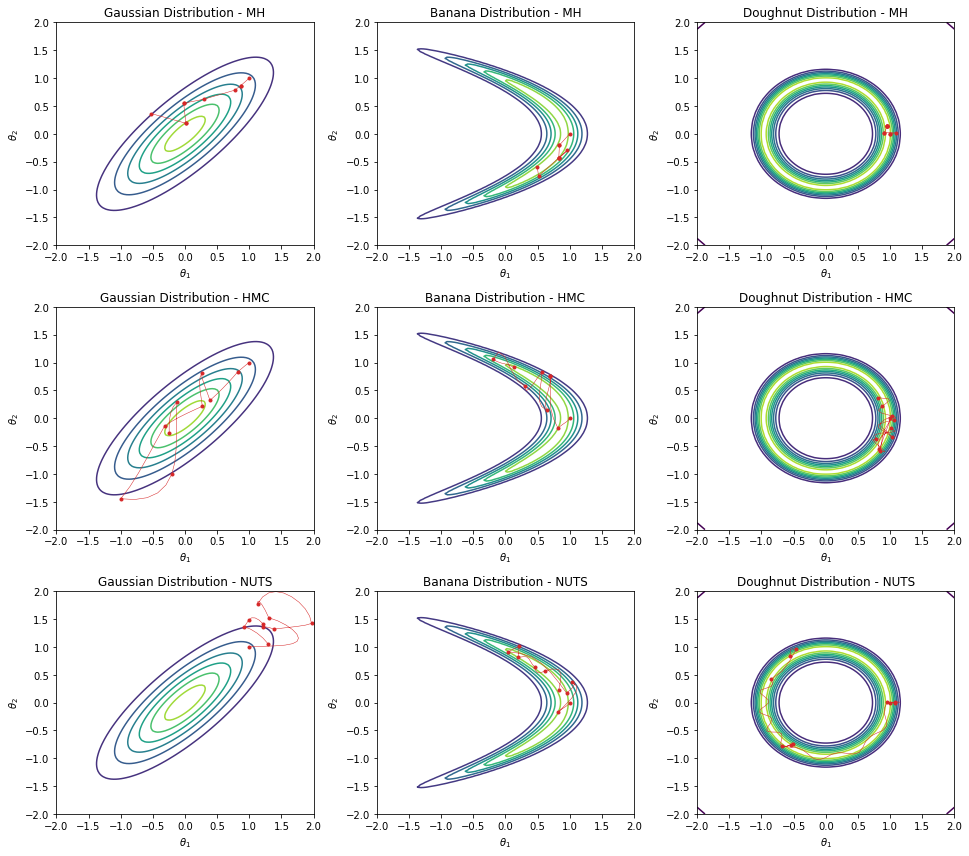

In [ ]:
### First n genereated samples
n = 10
plt.figure(figsize=(13.5,12))
plt.subplot(3,3,1)
plt.contour(X, Y, Z_gaussian)
plt.plot(samples_gaussian_mh[0:n,0], samples_gaussian_mh[0:n,1], '.-', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - MH')
plt.subplot(3,3,2)
plt.contour(X, Y, Z_banana)
plt.plot(samples_banana_mh[0:n,0], samples_banana_mh[0:n,1], '.-', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - MH')
plt.subplot(3,3,3)
plt.contour(X, Y, Z_doughnut)
plt.plot(samples_doughnut_mh[0:n,0], samples_doughnut_mh[0:n,1], '.-', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - MH')
plt.subplot(3,3,4)
plt.contour(X, Y, Z_gaussian)
plt.plot(np.vstack(paths_gaussian_hmc[0:n-1])[:,0], np.vstack(paths_gaussian_hmc[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_gaussian_hmc[0:n,0], samples_gaussian_hmc[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - HMC')
plt.subplot(3,3,5)
plt.contour(X, Y, Z_banana)
plt.plot(np.vstack(paths_banana_hmc[0:n-1])[:,0], np.vstack(paths_banana_hmc[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_banana_hmc[0:n,0], samples_banana_hmc[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - HMC')
plt.subplot(3,3,6)
plt.contour(X, Y, Z_doughnut)
plt.plot(np.vstack(paths_doughnut_hmc[0:n-1])[:,0], np.vstack(paths_doughnut_hmc[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_doughnut_hmc[0:n,0], samples_doughnut_hmc[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - HMC')
plt.subplot(3,3,7)
plt.contour(X, Y, Z_gaussian)
plt.plot(np.vstack(paths_gaussian_nuts[0:n-1])[:,0], np.vstack(paths_gaussian_nuts[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_gaussian_nuts[0:n,0], samples_gaussian_nuts[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Gaussian Distribution - NUTS')
plt.subplot(3,3,8)
plt.contour(X, Y, Z_banana)
plt.plot(np.vstack(paths_banana_nuts[0:n-1])[:,0], np.vstack(paths_banana_nuts[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_banana_nuts[0:n,0], samples_banana_nuts[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Banana Distribution - NUTS')
plt.subplot(3,3,9)
plt.contour(X, Y, Z_doughnut)
plt.plot(np.vstack(paths_doughnut_nuts[0:n-1])[:,0], np.vstack(paths_doughnut_nuts[0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
plt.plot(samples_doughnut_nuts[0:n,0], samples_doughnut_nuts[0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title('Doughnut Distribution - NUTS')
plt.tight_layout()
plt.savefig('comparisson_trajectory.png', dpi=300, transparent=True)
plt.show()

## Hamiltonian Monte Carlo hyperparameters

In [ ]:
epsilon_array = [0.01, 0.1, 0.5]
L_array = [1, 5, 10]
dist_Z = [Z_gaussian, Z_banana, Z_doughnut]
dist_names = ['Gaussian', 'Banana', 'Doughnut']
hmc_epsilon = []
for epsilon in epsilon_array:
    hmc_epsilon.append(HMC(dist=gaussian_dist, x0=np.array([[1.0], [1.0]]), epsilon=epsilon, M=np.eye(2), return_leapfrog_paths=True))
    hmc_epsilon.append(HMC(dist=banana_dist, x0=np.array([[1.0], [0.0]]), epsilon=epsilon, M=np.eye(2), return_leapfrog_paths=True))
    hmc_epsilon.append(HMC(dist=doughnut_dist, x0=np.array([[1.0], [0.0]]), epsilon=epsilon, M=np.eye(2), return_leapfrog_paths=True))
hmc_L = []
for L in L_array:
    hmc_L.append(HMC(dist=gaussian_dist, x0=np.array([[1.0], [1.0]]), L=L, M=np.eye(2), return_leapfrog_paths=True))
    hmc_L.append(HMC(dist=banana_dist, x0=np.array([[1.0], [0.0]]), L=L, M=np.eye(2), return_leapfrog_paths=True))
    hmc_L.append(HMC(dist=doughnut_dist, x0=np.array([[1.0], [0.0]]), L=L, M=np.eye(2), return_leapfrog_paths=True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in matmul


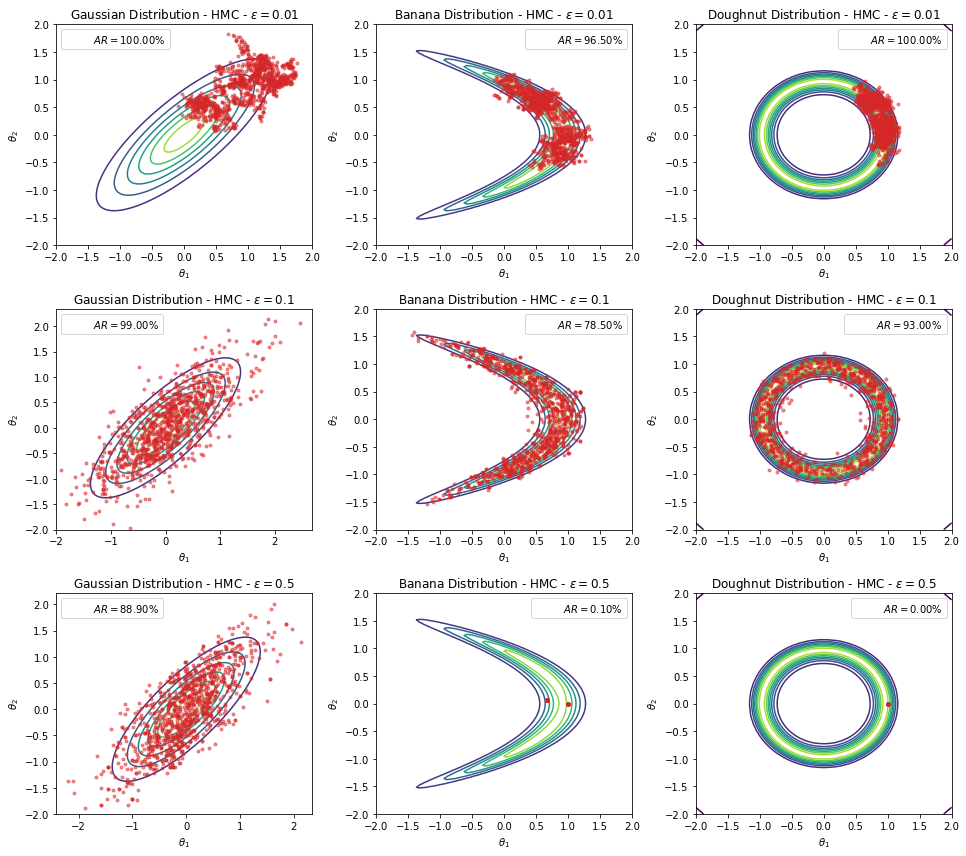

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(hmc_epsilon)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(hmc_epsilon[i][0][:,0], hmc_epsilon[i][0][:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
    plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * hmc_epsilon[i][1]))
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - HMC - $\epsilon={}$'.format(dist_names[i % 3], epsilon_array[idx]))
    plt.legend()
plt.tight_layout()
plt.savefig('hmc_epsilon_ar.png', dpi=300, transparent=True)
plt.show()

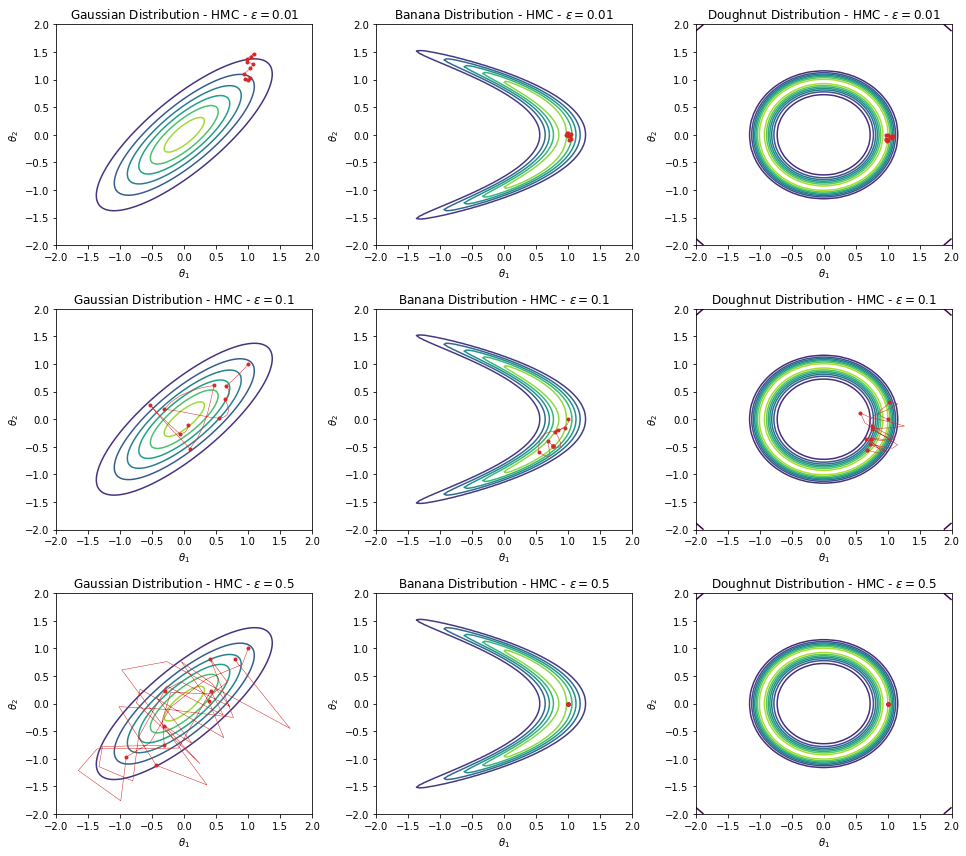

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(hmc_epsilon)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(np.vstack(hmc_epsilon[i][2][0:n-1])[:,0], np.vstack(hmc_epsilon[i][2][0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
    plt.plot(hmc_epsilon[i][0][0:n,0], hmc_epsilon[i][0][0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - HMC - $\epsilon={}$'.format(dist_names[i % 3], epsilon_array[idx]))
plt.tight_layout()
plt.savefig('hmc_epsilon_trayectory.png', dpi=300, transparent=True)
plt.show()

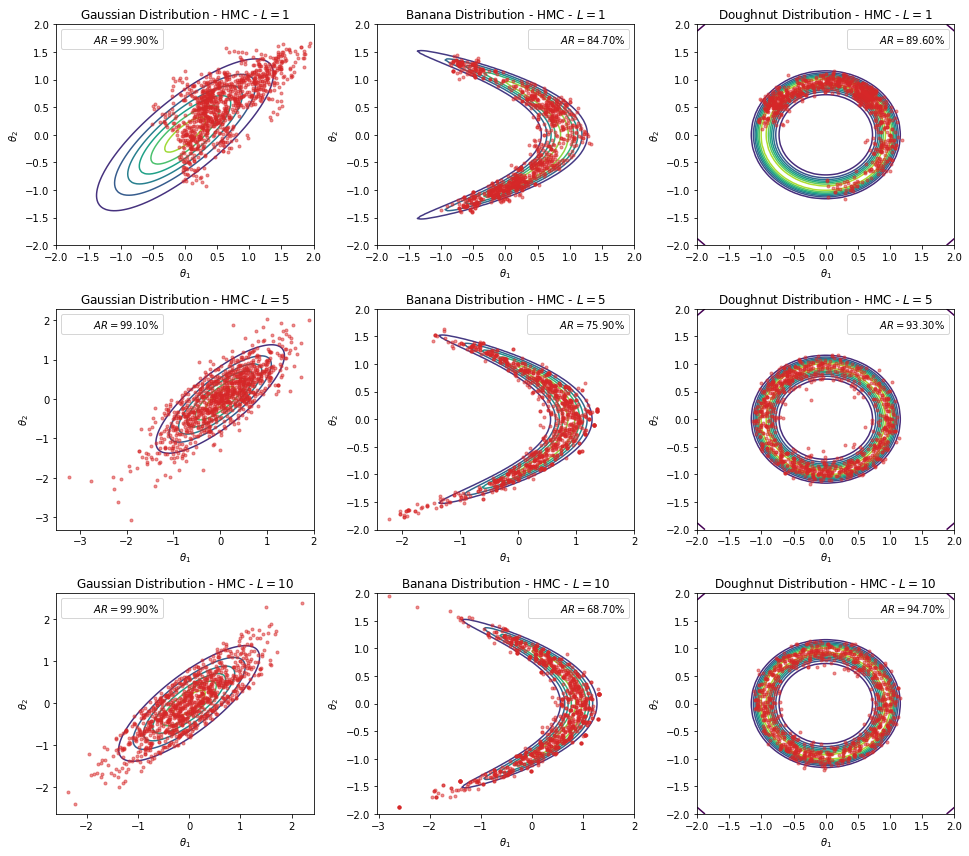

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(hmc_L)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(hmc_L[i][0][:,0], hmc_L[i][0][:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
    plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * hmc_L[i][1]))
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - HMC - $L={}$'.format(dist_names[i % 3], L_array[idx]))
    plt.legend()
plt.tight_layout()
plt.savefig('hmc_L_ar.png', dpi=300, transparent=True)
plt.show()

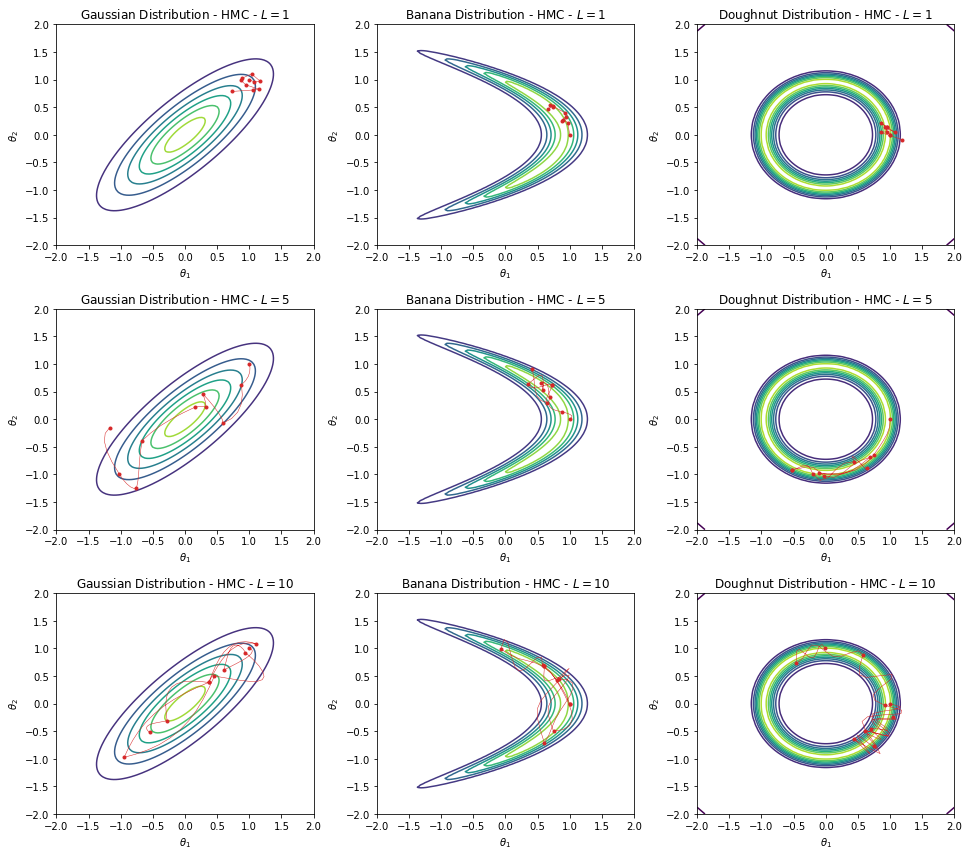

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(hmc_L)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(np.vstack(hmc_L[i][2][0:n-1])[:,0], np.vstack(hmc_L[i][2][0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
    plt.plot(hmc_L[i][0][0:n,0], hmc_L[i][0][0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - HMC - $L={}$'.format(dist_names[i % 3], L_array[idx]))
plt.tight_layout()
plt.savefig('hmc_L_trajectory.png', dpi=300, transparent=True)
plt.show()

## No-U-Turn Sampler hyperparameters

In [ ]:
epsilon_array = [0.01, 0.1, 1]
dist_Z = [Z_gaussian, Z_banana, Z_doughnut]
dist_names = ['Gaussian', 'Banana', 'Doughnut']
nuts_epsilon = []
for epsilon in epsilon_array:
    nuts_epsilon.append(NUTS(dist=gaussian_dist, θ0=np.array([[1.0], [1.0]]), ϵ=epsilon, return_leapfrog_paths=True))
    nuts_epsilon.append(NUTS(dist=banana_dist, θ0=np.array([[1.0], [0.0]]), ϵ=epsilon, return_leapfrog_paths=True))
    nuts_epsilon.append(NUTS(dist=doughnut_dist, θ0=np.array([[1.0], [0.0]]), ϵ=epsilon, return_leapfrog_paths=True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in exp


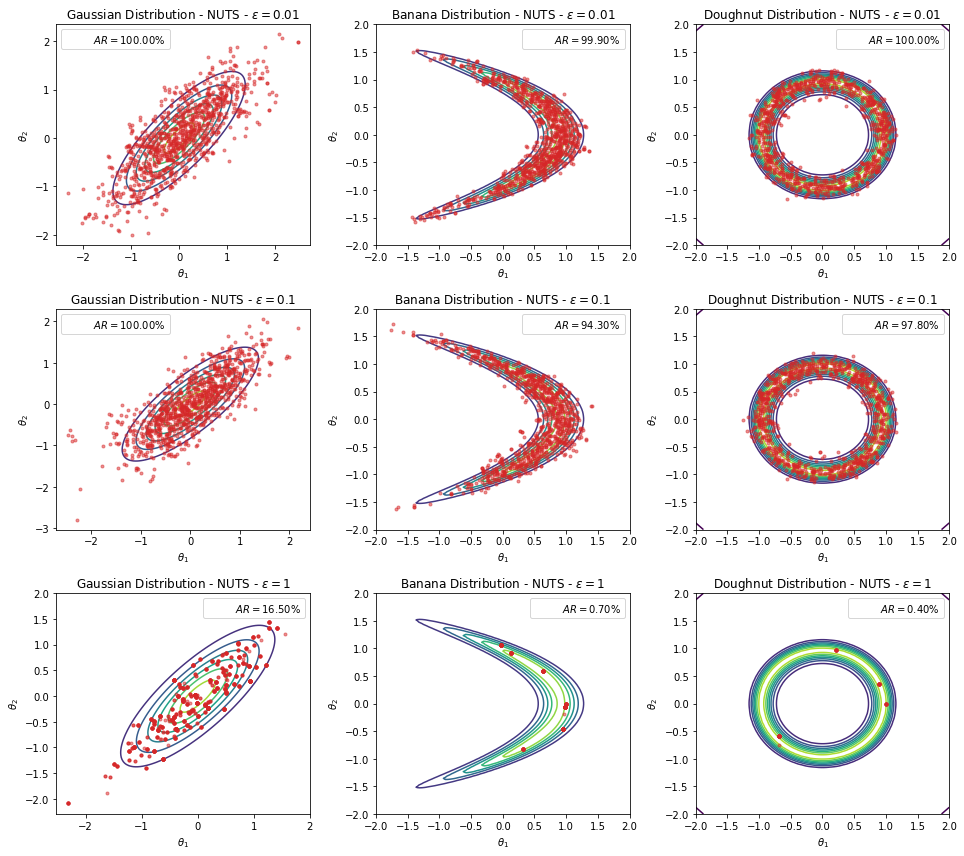

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(nuts_epsilon)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(nuts_epsilon[i][0][:,0], nuts_epsilon[i][0][:,1], '.', color='tab:red', linewidth=.5, alpha=.5)
    plt.plot([], [], ' ', label=r'$AR={:.2f}\%$'.format(100 * nuts_epsilon[i][1]))
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - NUTS - $\epsilon={}$'.format(dist_names[i % 3], epsilon_array[idx]))
    plt.legend()
plt.tight_layout()
plt.savefig('nuts_epsilon_ar.png', dpi=300, transparent=True)
plt.show()

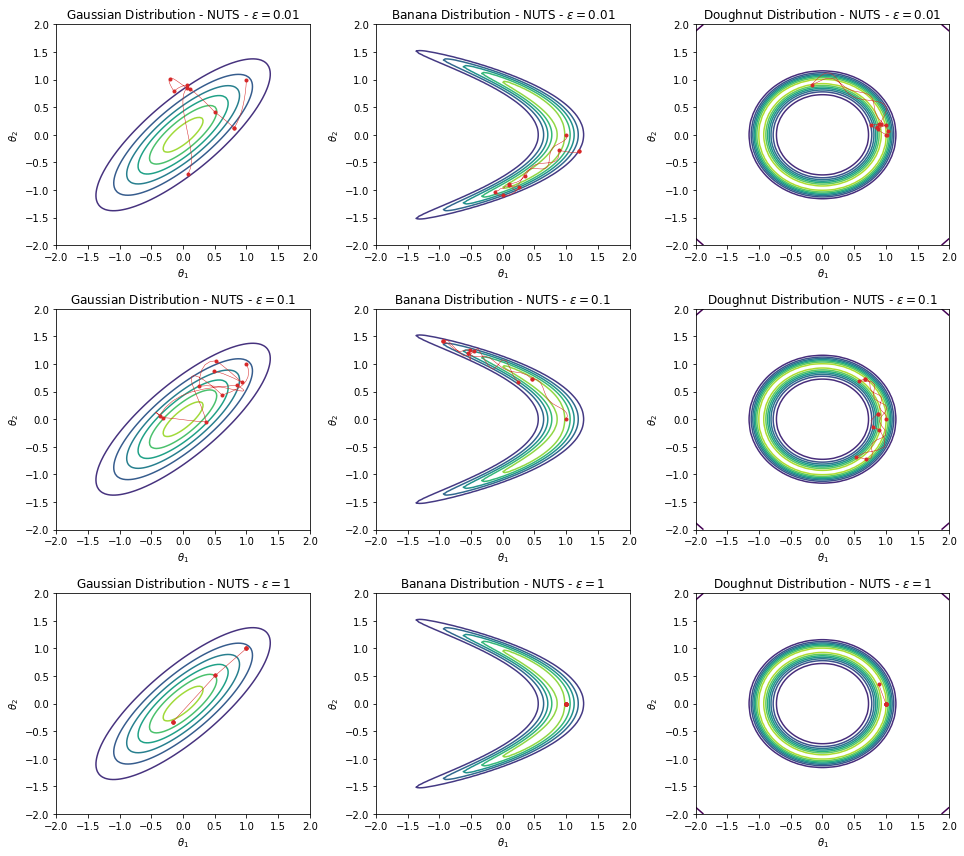

In [ ]:
plt.figure(figsize=(13.5,12))
for i in range(len(nuts_epsilon)):
    plt.subplot(3,3,i+1)
    plt.contour(X, Y, dist_Z[i % 3])
    plt.plot(np.vstack(nuts_epsilon[i][2][0:n-1])[:,0], np.vstack(nuts_epsilon[i][2][0:n-1])[:,1], color='tab:red', linewidth=.5, alpha=1)
    plt.plot(nuts_epsilon[i][0][0:n,0], nuts_epsilon[i][0][0:n,1], '.', color='tab:red', linewidth=.5, alpha=1)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    if i > 2:
        idx = 1
    if i > 5:
        idx = 2
    if i <= 2:
        idx = 0
    plt.title(r'{} Distribution - NUTS - $\epsilon={}$'.format(dist_names[i % 3], epsilon_array[idx]))
plt.tight_layout()
plt.savefig('nuts_epsilon_trajectory.png', dpi=300, transparent=True)
plt.show()

## Dimensionality Test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in exp


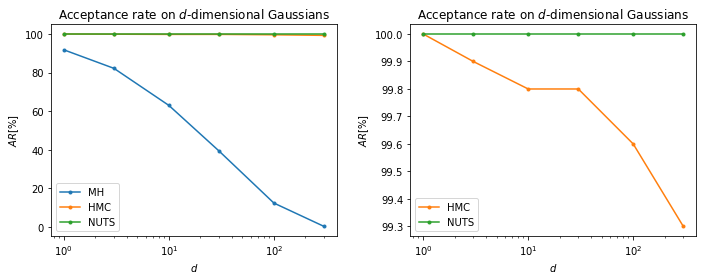

In [ ]:
### Acceptance Rate Test
D = [1, 3, 10, 30, 100, 300]
ar_D = []
for d in tqdm(D):
    gaussianD_dist = GaussianDist(mean=np.zeros(shape=(d,1)), cov=np.eye(d))
    _, ar_gaussianD_mh = MH(dist=gaussianD_dist, x0=np.ones(shape=(d,1)), M=0.1*np.eye(d))
    _, ar_gaussianD_hmc = HMC(dist=gaussianD_dist, x0=np.ones(shape=(d,1)), M=np.eye(d))
    _, ar_gaussianD_nuts = NUTS(dist=gaussianD_dist, θ0=np.ones(shape=(d,1)))
    ar_D.append([ar_gaussianD_mh, ar_gaussianD_hmc, ar_gaussianD_nuts])
ar_D = np.array(ar_D).T

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(D, ar_D[0,:] * 100, '.-', label='MH')
plt.plot(D, ar_D[1,:] * 100, '.-', label='HMC')
plt.plot(D, ar_D[2,:] * 100, '.-', label='NUTS')
plt.xscale('log')
plt.xlabel(r'$d$')
plt.ylabel(r'$AR[\%]$')
plt.title(r'Acceptance rate on $d$-dimensional Gaussians')
plt.legend()
plt.subplot(1,2,2)
plt.plot([], [])
plt.plot(D, ar_D[1,:] * 100, '.-', label='HMC')
plt.plot(D, ar_D[2,:] * 100, '.-', label='NUTS')
plt.xscale('log')
plt.xlabel(r'$d$')
plt.ylabel(r'$AR[\%]$')
plt.title(r'Acceptance rate on $d$-dimensional Gaussians')
plt.legend()
plt.tight_layout()
plt.savefig('dimensionality_test.png', dpi=300, transparent=True)
plt.show()